# ASHRAE Energy Predictions:

### Import of necessary packages:

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt   

### Loading data:

In [2]:
train = pd.read_csv('ashrae-energy-prediction/train.csv')
test = pd.read_csv('ashrae-energy-prediction/test.csv')
weather_train= pd.read_csv('ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
meta = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [3]:
print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))
print('weather_train shape is {}'.format(weather_train.shape))
print('weather_test shape is {}'.format(weather_test.shape))
print('metadata shape is {}'.format(meta.shape))

train shape is (20216100, 4)
test shape is (41697600, 4)
weather_train shape is (139773, 9)
weather_test shape is (277243, 9)
metadata shape is (1449, 6)


### Merging data:

In [4]:
train = train.merge(meta, on = 'building_id', how = 'left')
test = test.merge(meta, on = 'building_id', how = 'left')
train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train,weather_test

In [24]:
train.shape

(20216100, 16)

In [25]:
test.shape

(41697600, 16)

### Categorical/continuous variable:

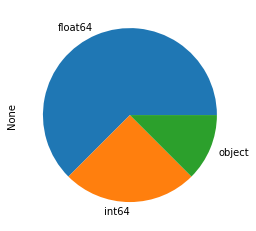

In [27]:
train.dtypes.value_counts().plot.pie()

### Memory reduction:

In [6]:
def memory_reduction(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train = memory_reduction(train)
test = memory_reduction(test)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 790.78 MB
Decreased by 69.8%
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.04 MB
Decreased by 69.8%


### Missing values:

In [5]:
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]         # ce qu'il apparait le plus souvent 
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing})
    print('total empty percent:', percent_empty, '%')
    return(missing_value_df)

In [6]:
get_missing_info(train)

total empty percent: 13.736697174529212 %


,num_missing,percent_missing
building_id,0,0.000000
meter,0,0.000000
timestamp,0,0.000000
meter_reading,0,0.000000
site_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000
year_built,12127645,59.990033
floor_count,16709167,82.652772
air_temperature,96658,0.478124


### Converting datetime variable 'timestamp':

In [12]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
#train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)


test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

### Defining function to plot distributions:

In [9]:
def distplot(var,color):
    plt.rcParams['figure.figsize'] = (10, 8)
    ax = sns.distplot(var, color = color)
    plt.xlabel('%s' %var.name, fontsize =14)
    plt.ylabel('Count ', fontsize =14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(' Distribution of '+'%s' %var.name)
    plt.show()

In [7]:
# fig,ax = plt.subplots(126,4,figsize=(24,504))
# i=0
# j=0

# for b_id in range(0,1449):
#     if b_id <500:
#         ax[i][j].set_title(f'Building {b_id} Meter 0')
#         ax[i][j]=plt.plot(train[(train.building_id == b_id) & (train.meter ==0 )]['timestamp'], train[(train.building_id == b_id) & (train.meter == 0)]['meter_reading'])
#         j+=1
#         if j==1:
#             j+=1
#             j=0
#     else:
#         break
# plt.show()

#### Distribution of target variable: meter_reading

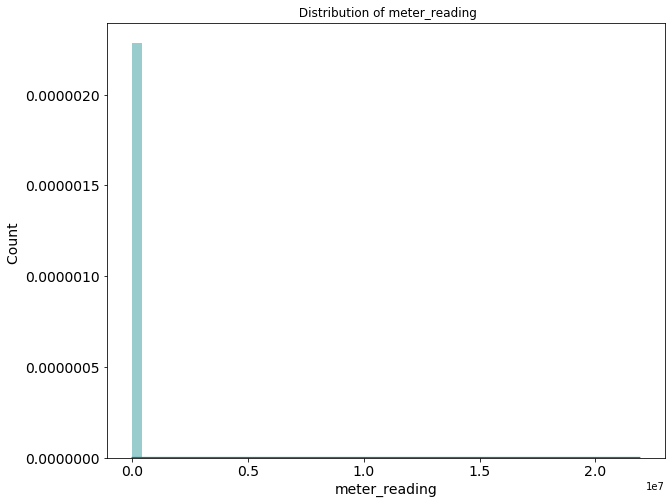

In [35]:
distplot(train['meter_reading'], 'teal')

In [36]:
train['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [41]:
(train['meter_reading']==0).value_counts()

False    18342124
True      1873976
Name: meter_reading, dtype: int64

#### Convert meter_reading to log1p(meter_reading):

In [5]:
train['meter_reading'] = np.log1p(train['meter_reading'])

#### Distribution of log1p(meter_reading):

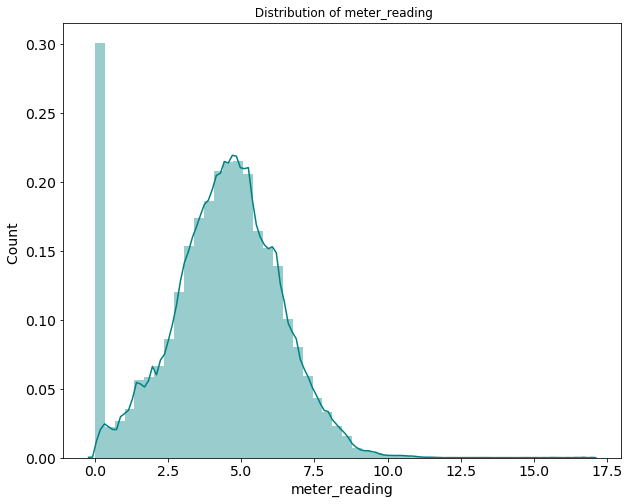

In [44]:
distplot(train['meter_reading'],'teal')   # distribution après le passage en log 

#### Distribution of meter_type:

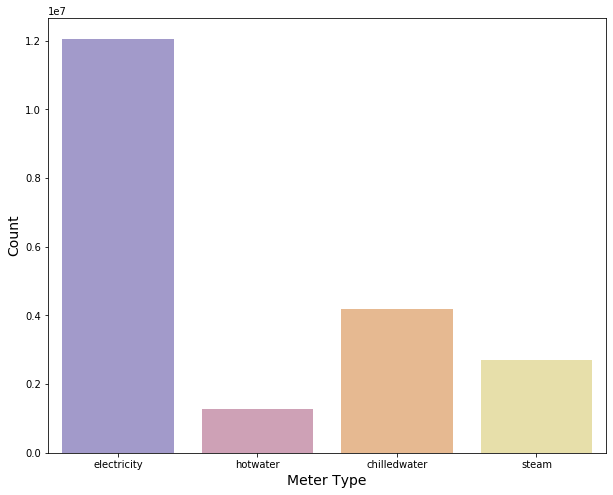

In [45]:
plt.rcParams['figure.figsize'] = (10, 8)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Meter Type', fontsize = 14)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
n, bins, patches = ax.hist(meta.site_id, bins=15)
for number, b in zip(n, bins[:-1]):
    ax.annotate(int(number), 
                 xy=(b+.5, number), xytext=(0, 1),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)
ax.set_xticks(np.arange(0.5, 15., step=1))
ax.set_xticklabels(np.arange(0, 16))
ax.set_ylim([0, 300])
ax.set_xlabel('site_id')
ax.set_ylabel('number of buildings')
ax.set_title('Number of buildings in each site', fontsize=16);

#### boxplot of log1p(meter_reading) according to weekdays:

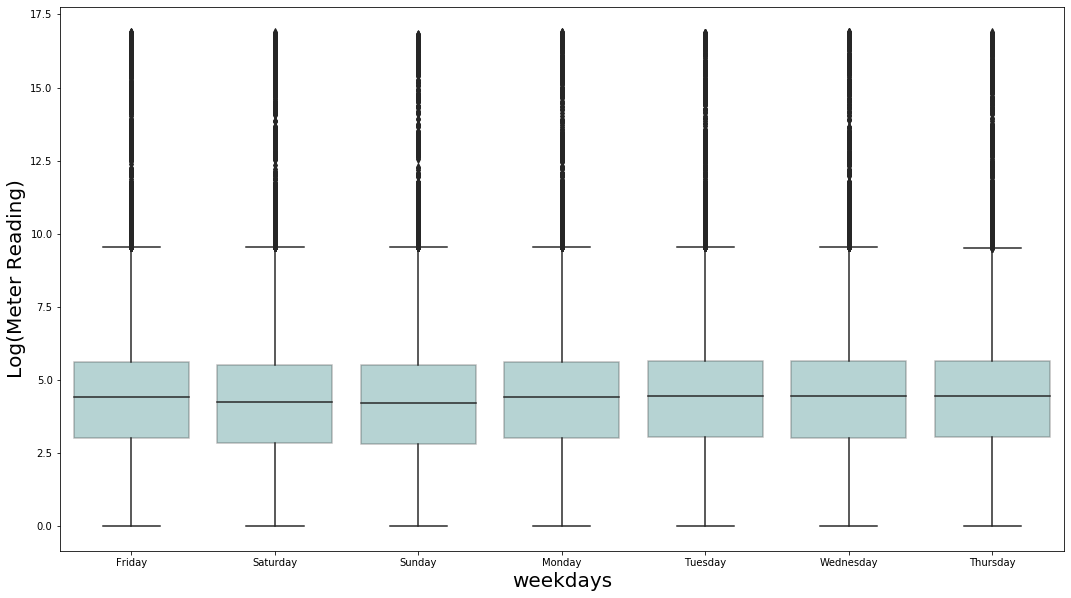

In [28]:
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.boxplot(data = train, x ='weekday_name', y = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekdays', fontsize = 20)
plt.show()

=> Sundays have the lowest reading

#### meter_reading every hour:

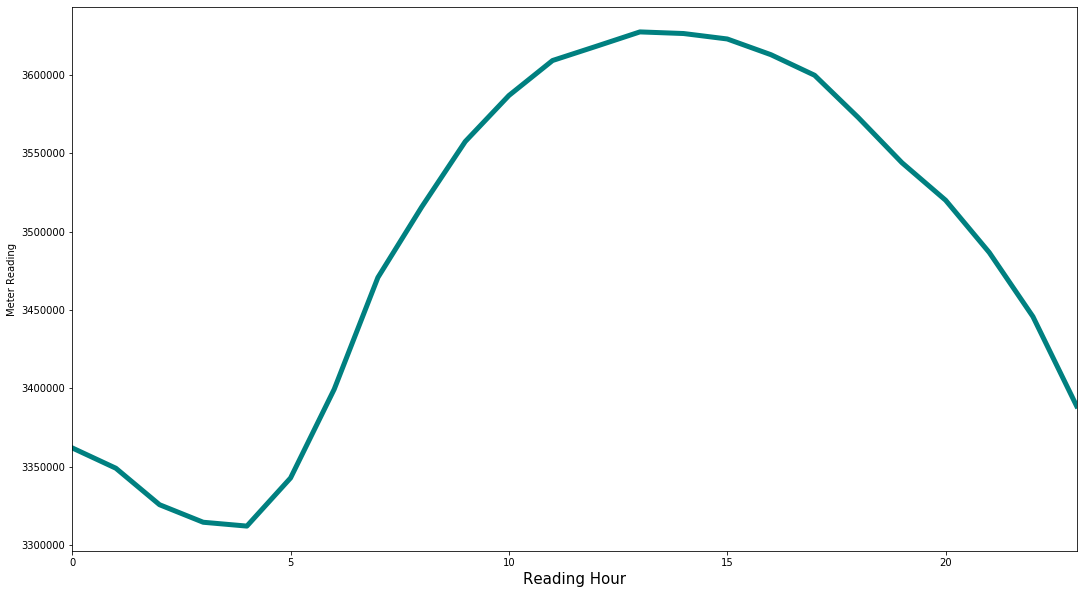

In [29]:
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('hour').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

high consumption between 7 am and 8 pm

#### Categorial variables:

In [46]:
for col in train.select_dtypes('category'):
    print(col)

timestamp
primary_use


In [47]:
for col in train.select_dtypes('object'):
    print(col)

meter
weekday_name


**primary_use:**

In [49]:
train['primary_use'].value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

#### log1p(meter_reading) according to primary_use:

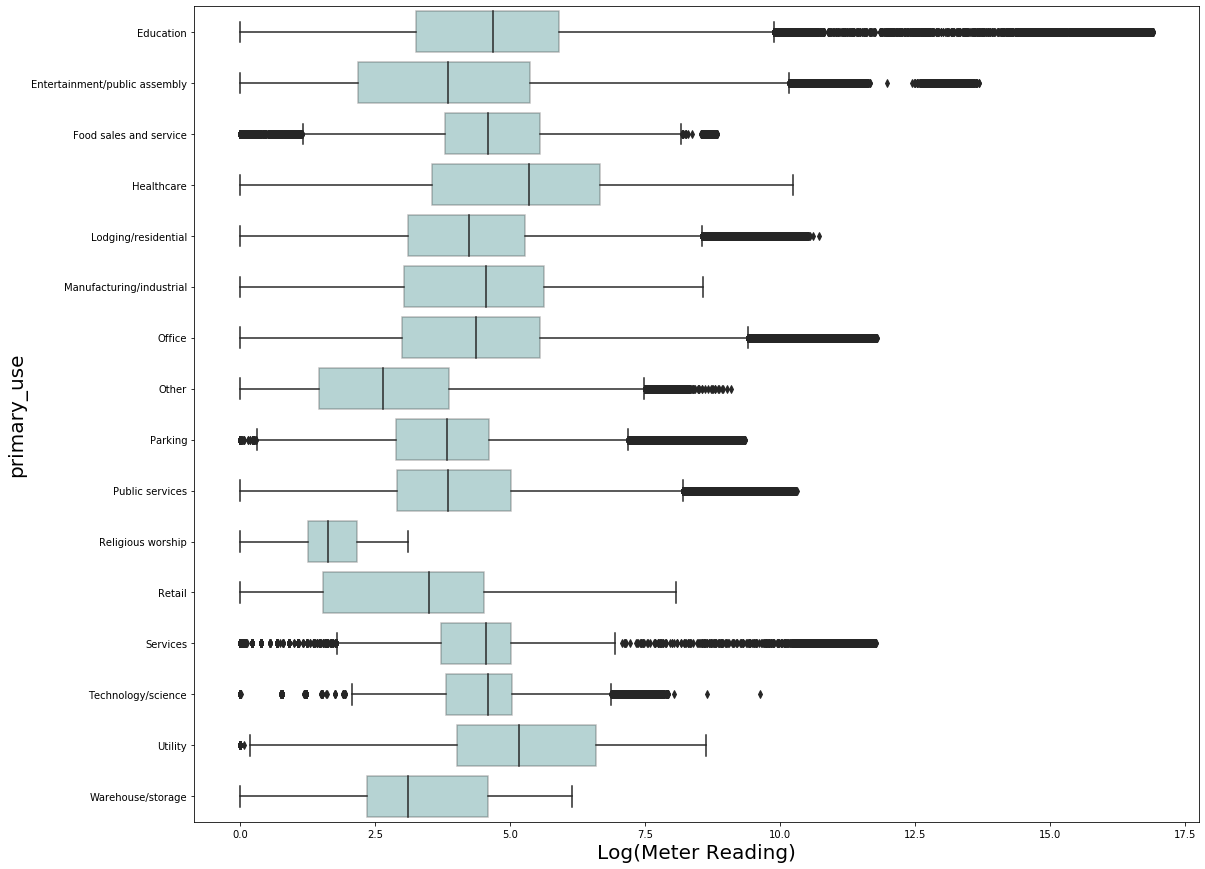

In [50]:
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = train, x = 'meter_reading', y = 'primary_use',color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

- Utility and healthcare uses have the highest meter reading
- Religious use have the lowest meter reading

#### log1p(meter_reading) each month:

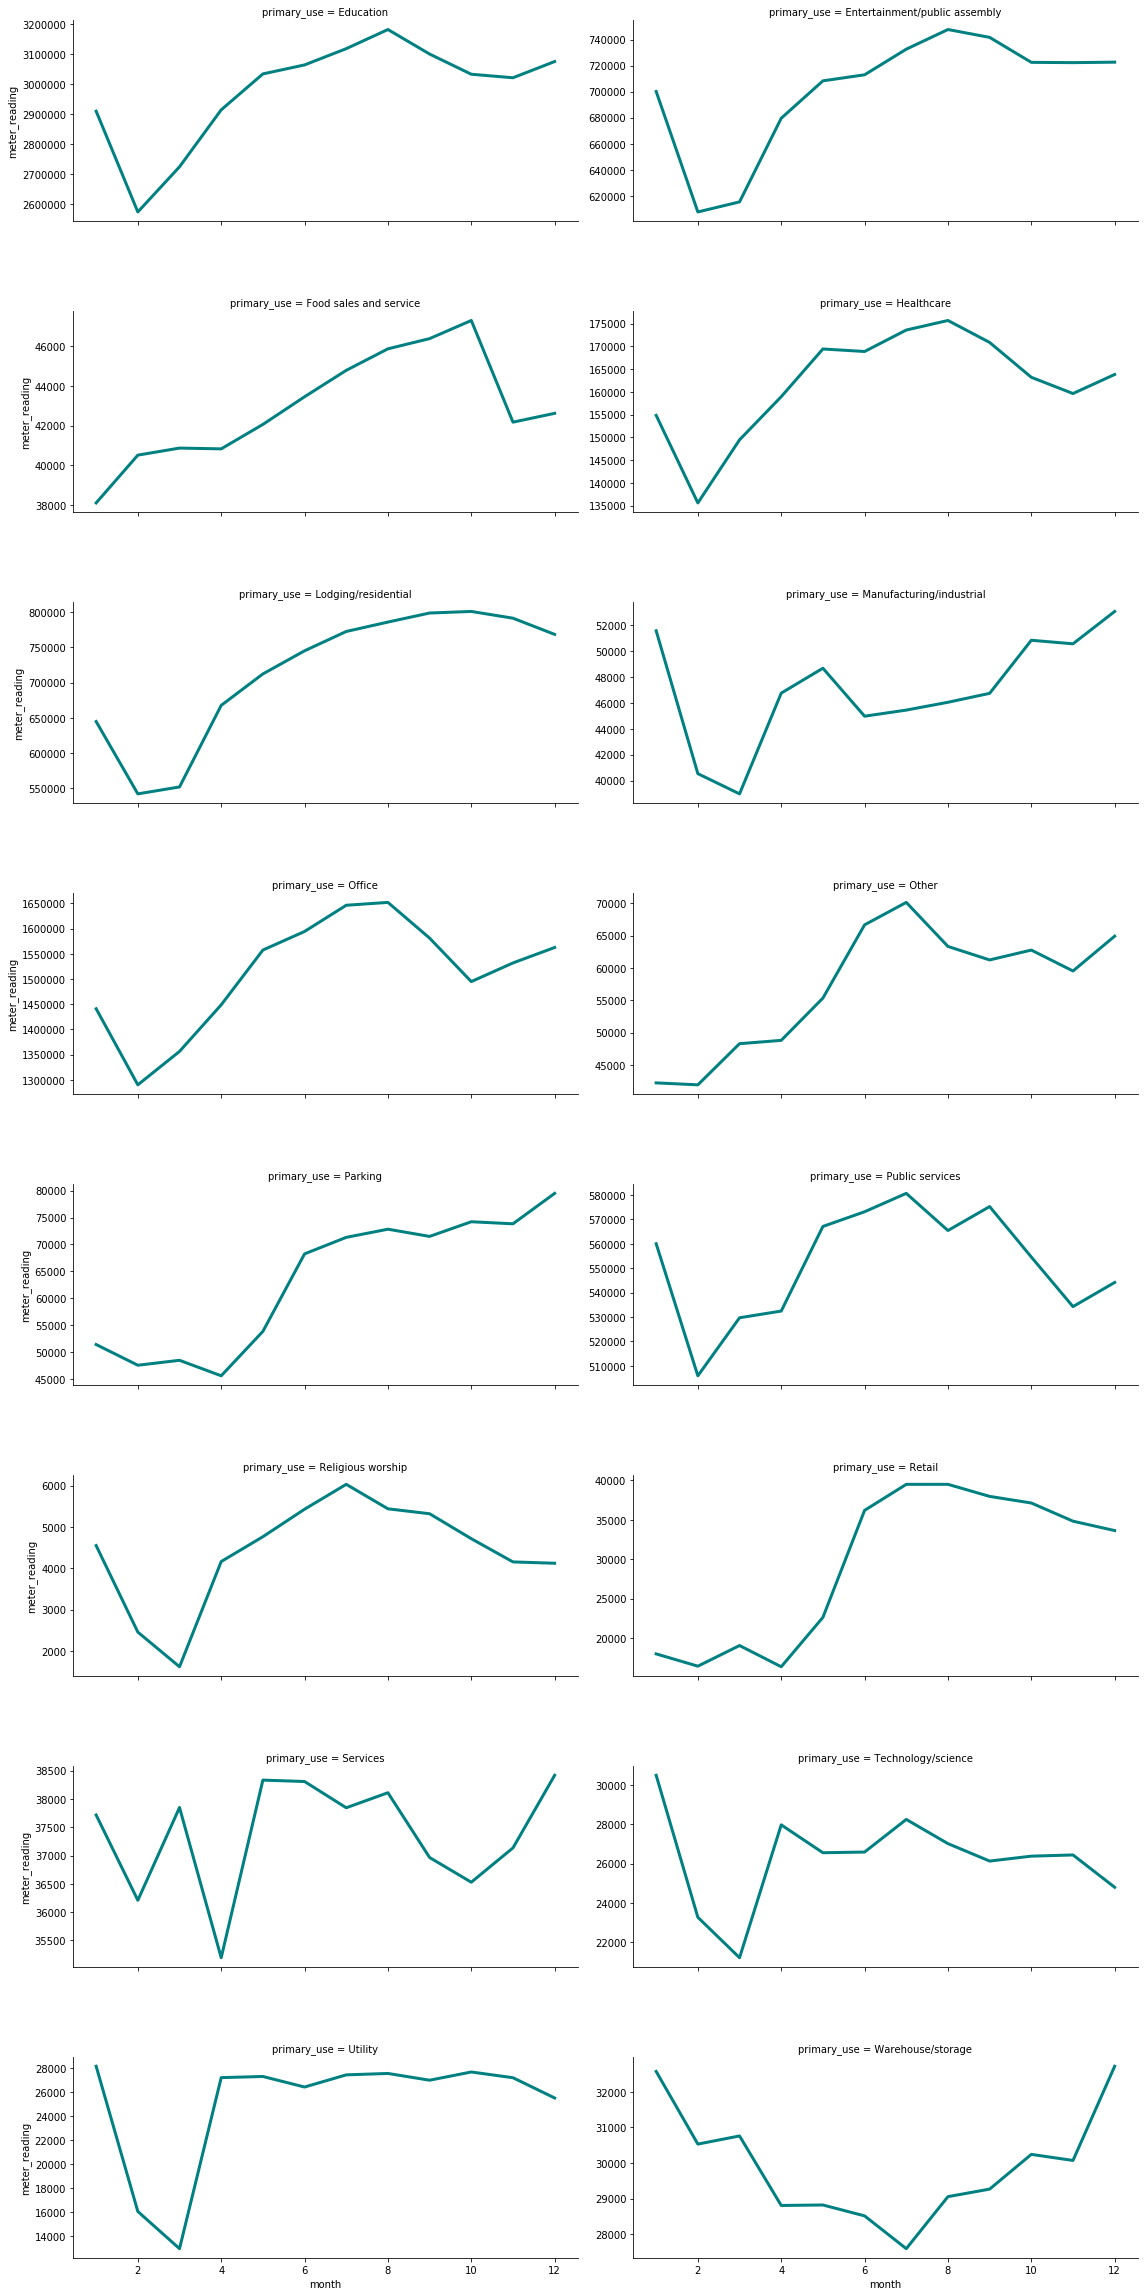

In [34]:
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

Le peack est souvent atteint en fin d'année! à cause du froid.

#### log1p(meter_reading) for each use:

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


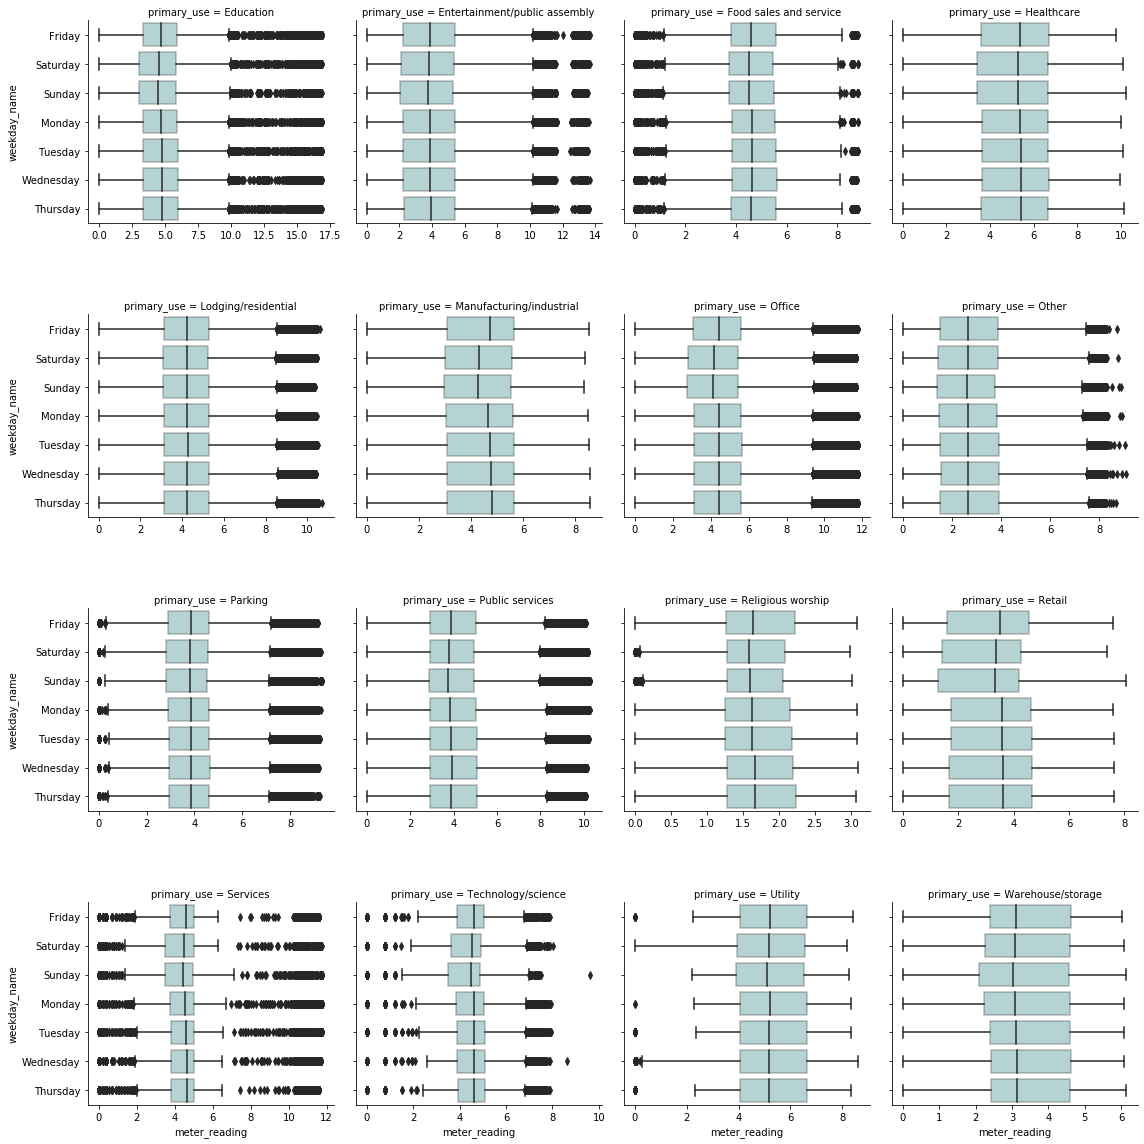

In [35]:
ax = sns.FacetGrid(train, col="primary_use", col_wrap=4, height=4, aspect=1,  sharex=False)
ax.map(sns.boxplot, 'meter_reading', 'weekday_name', color="teal",   boxprops=dict(alpha=.3))
plt.subplots_adjust(hspace=0.45)
plt.show()

#### Confusion matrix:

variables that have a great correlation with the target variable are:

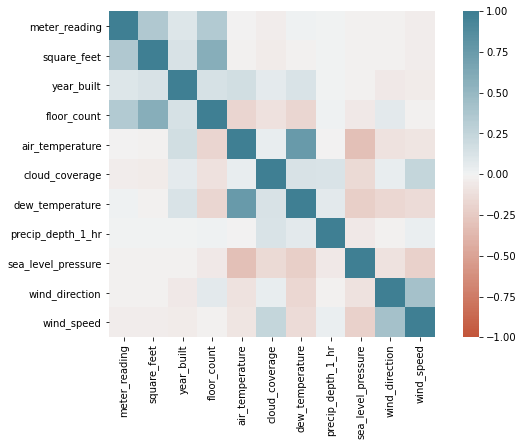

In [6]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(train.drop(["building_id","site_id","timestamp","meter","primary_use"], axis=1).corr(), vmin=-1, vmax=1, center=0,cmap = sns.diverging_palette(20, 220, n=200),square=True)
plt.show()

### Consommation * square_feet

In [7]:
train[['meter_reading',"square_feet"]].corr(method='spearman')

,meter_reading,square_feet
meter_reading,1.000000,0.499369
square_feet,0.499369,1.000000


Text(0, 0.5, 'square_feet')

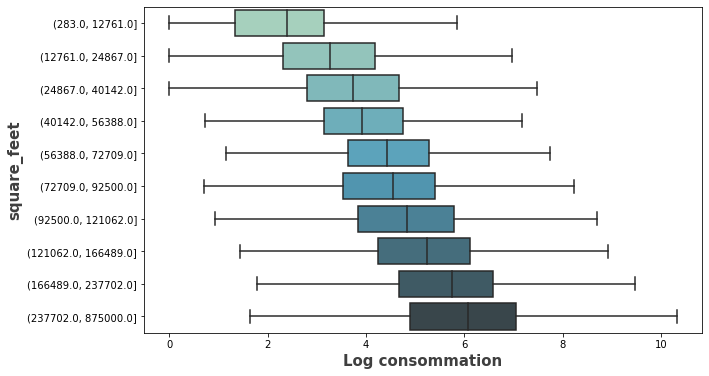

In [8]:
bins = np.around(np.quantile(train.square_feet,np.arange(0,11)/10))
train["binns"] = pd.cut(train["square_feet"], bins)

ax, fig = plt.subplots(figsize=(10,6))
ax = sns.boxplot(y="binns", x="meter_reading",palette="GnBu_d",data=train,showfliers=False)

plt.xlabel("Log consommation",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("square_feet",weight="bold", alpha=0.75, fontsize=15)

### Consommation * meter

In [ ]:
plt.figure(figsize=(6,3))
sns.boxplot(y="meter", x="meter_reading",palette="GnBu_d",data=train,showfliers=False)
plt.xlabel("Log consommation",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("meter",weight="bold", alpha=0.75, fontsize=15)

### Consommation * primary_use

Text(0, 0.5, 'primary_use')

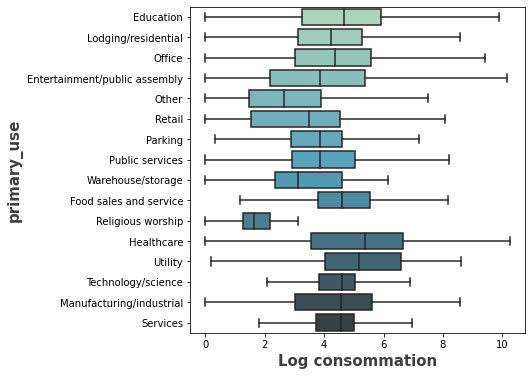

In [9]:
plt.figure(figsize=(6,6))
sns.boxplot(y="primary_use", x="meter_reading",palette="GnBu_d",data=train,showfliers=False)
plt.xlabel("Log consommation",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("primary_use",weight="bold", alpha=0.75, fontsize=15)

### Consommation * température

4714

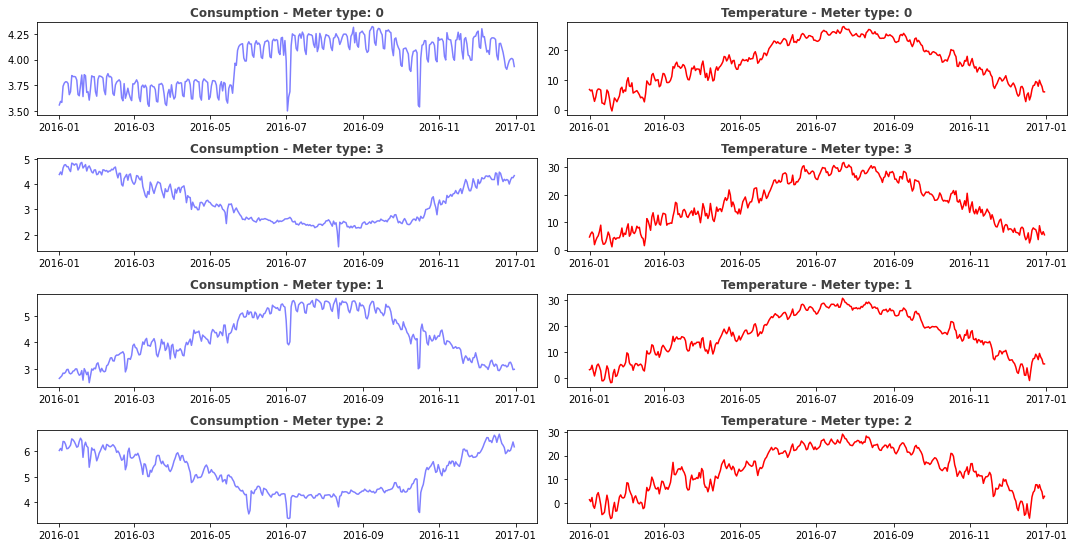

In [13]:
import datetime as dt
import gc

i = 0
m_types = train["meter"].unique()

fig,ax = plt.subplots(figsize=(15,15))
train.set_index(train["timestamp"],inplace=True)
for meter in m_types:
    i+=1
    meter_type = train[train["meter"] == meter]["meter_reading"].resample("D").mean()
    plt.subplot(8,2,i)
    plt.plot(meter_type,color="blue",alpha=0.5)
    plt.title("Consumption - Meter type: {}".format(meter), weight="bold", alpha=0.75)
    
    i+=1
    weather_data = train[train["meter"] == meter]["air_temperature"].resample("D").mean()
    plt.subplot(8,2,i)
    plt.plot(weather_data, color = "red")
    plt.title("Temperature - Meter type: {}".format(meter), weight="bold", alpha=0.75)
    plt.tight_layout(pad=1)


del meter_type, m_types, weather_data

gc.collect()

### Caractéristiques des batiments

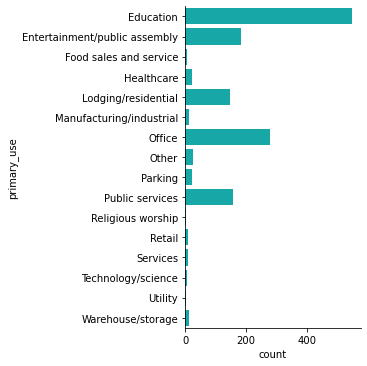

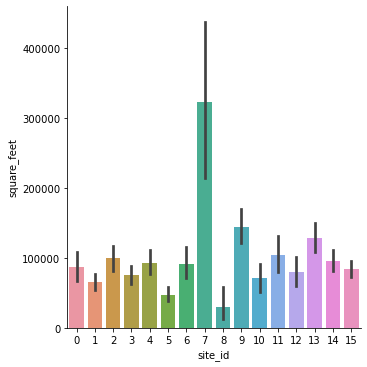

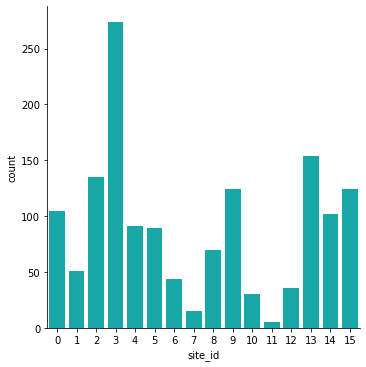

In [14]:
sns.catplot(y='primary_use',kind='count',data=meta.sort_values('primary_use'),color='c')
sns.catplot(x='site_id',y='square_feet',data=meta,kind='bar')
sns.catplot(x='site_id',data=meta,kind='count',color='c')

#### distribution of square_feet:

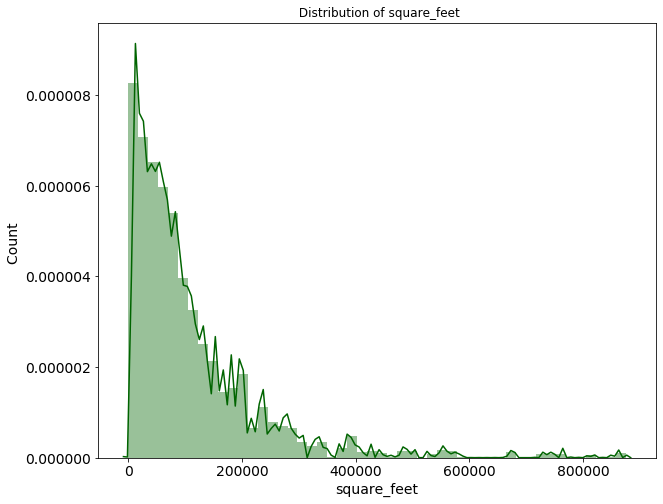

In [37]:
distplot(train['square_feet'], 'darkgreen')

#### distribution of log1p(square_feet) 

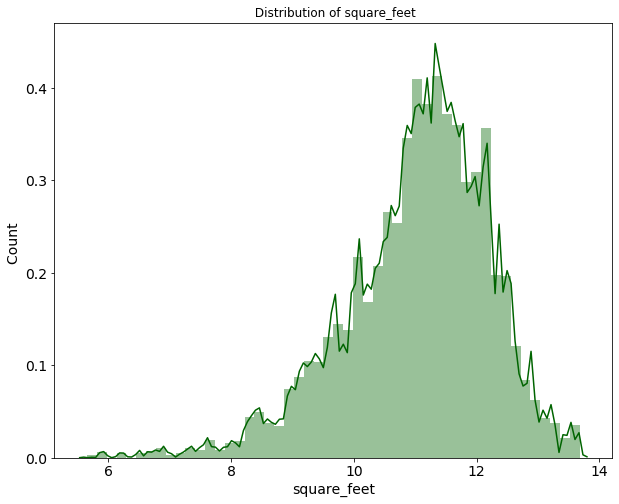

In [38]:
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

distplot(train['square_feet'], 'darkgreen')

#### ditribution of floor_count:

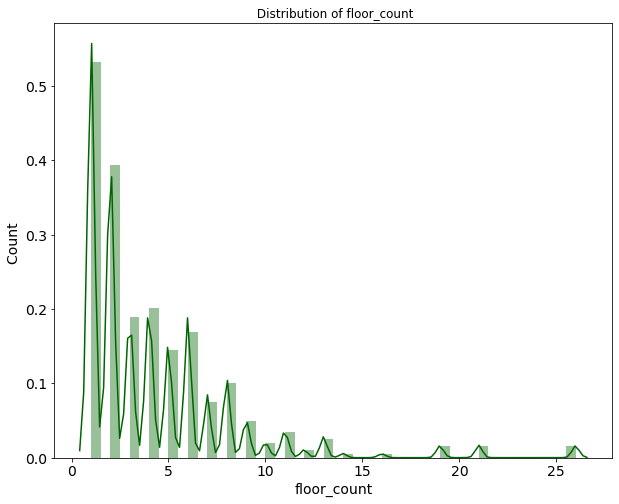

In [39]:
distplot(train['floor_count'].dropna(), 'darkgreen')

No many buildings having >= 10 floors.

#### density of air_temperature: 

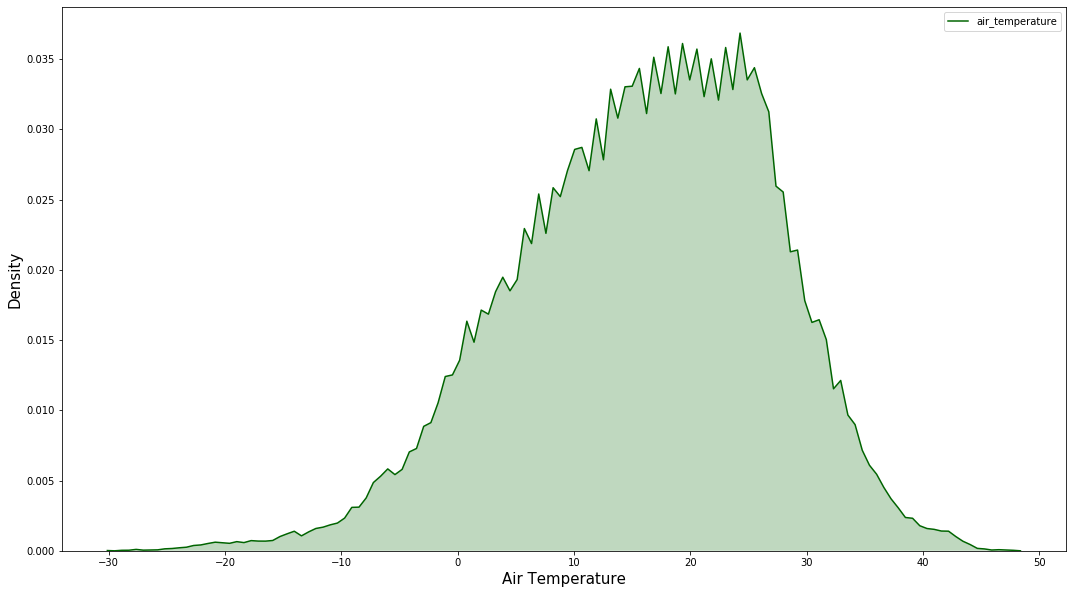

In [40]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['air_temperature'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Air Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### density of dew_temperature:

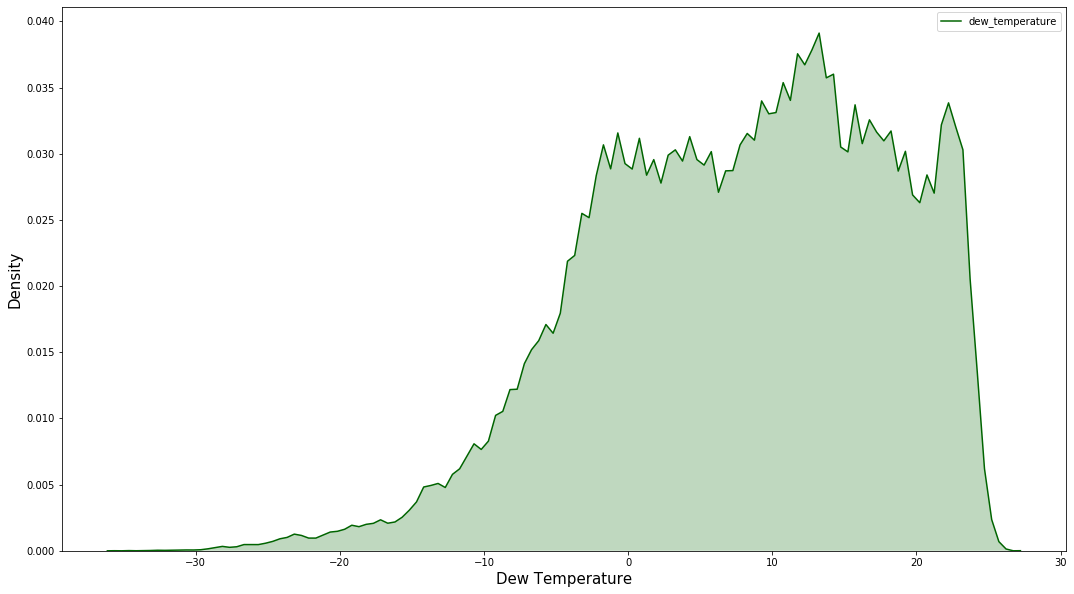

In [41]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['dew_temperature'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Dew Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### density of wind_speed:

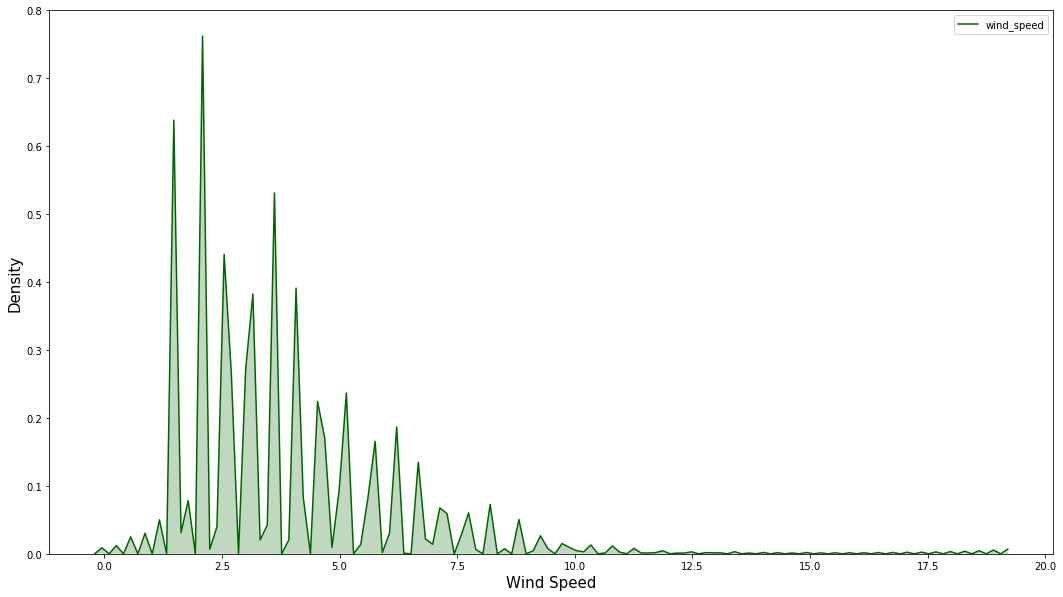

In [42]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['wind_speed'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### Imputing missing variables:

In [48]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,electricity,2016-01-01,0.0,0,0,8.913685,108,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
1,1,electricity,2016-01-01,0.0,0,0,7.908755,104,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
2,2,electricity,2016-01-01,0.0,0,0,8.589886,91,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
3,3,electricity,2016-01-01,0.0,0,0,10.072639,102,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
4,4,electricity,2016-01-01,0.0,0,0,11.666573,75,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1


### la consommation dans chaque site

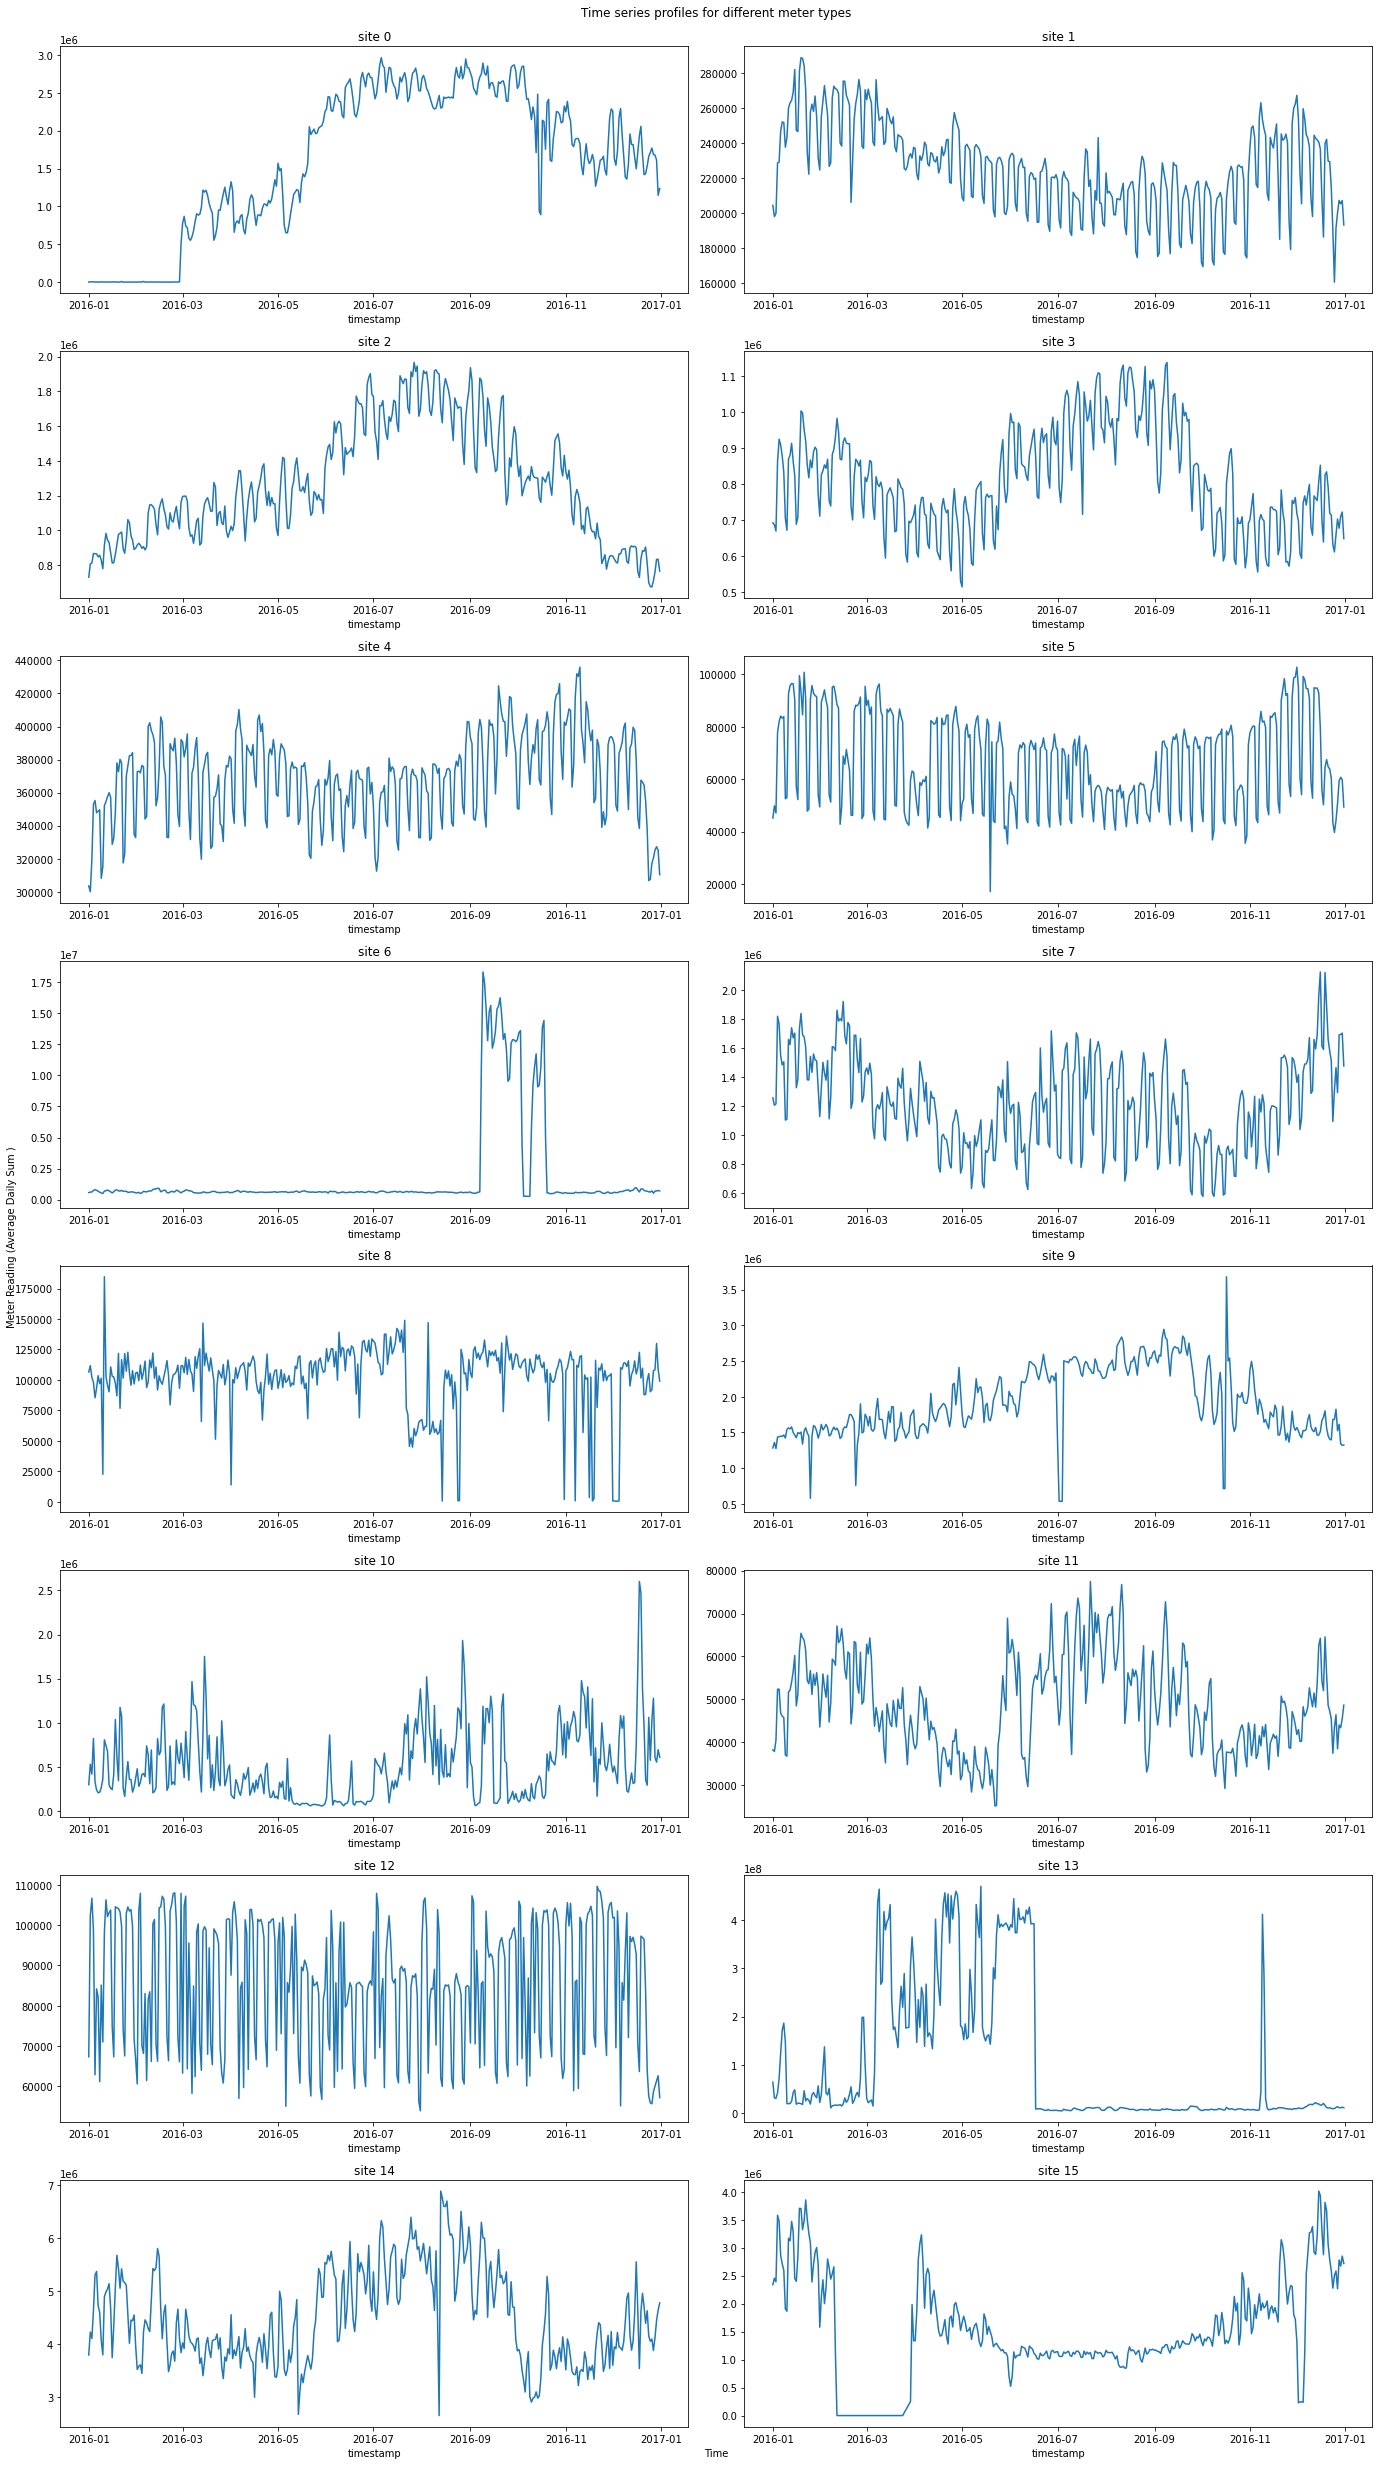

In [9]:
# Load profiles by site_id
site_daily_sum = train.groupby(['site_id', train.timestamp.dt.date])['meter_reading'].sum().reset_index()

fig, axes = plt.subplots(8, 2, figsize=(20, 35), tight_layout=True)
for i, ax in zip(range(16), axes.flat):
    site_daily_sum[site_daily_sum.site_id == i][['timestamp', 'meter_reading']].plot(ax = ax, x = 'timestamp', legend=False);
    ax.set_title(f'site {i}')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Average Daily Sum )', labelpad=20)

plt.title('Time series profiles for different meter types', pad=30)
plt.show()

### la consommation selon les tues d'activités dans les building

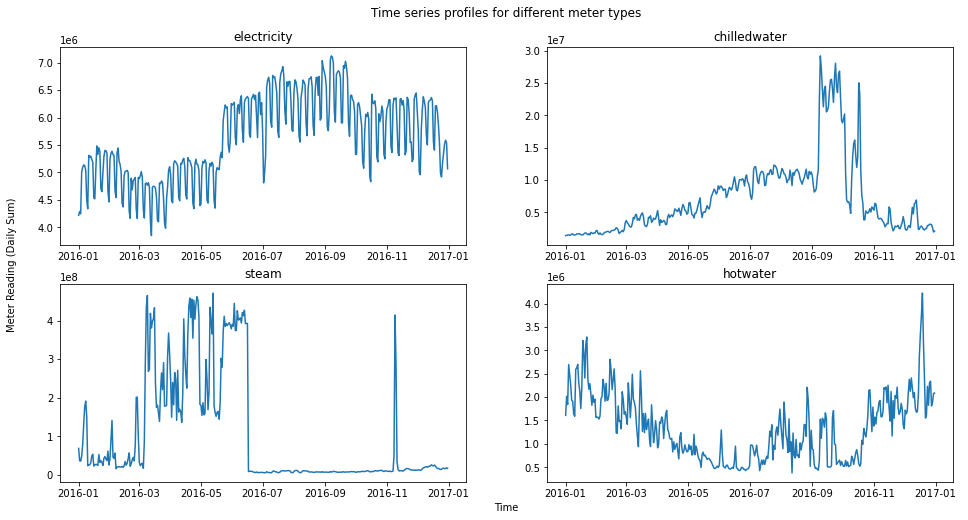

In [10]:
meters = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for ax, m in zip(axes.flat, meters): 
    meter_df = train[train['meter']==m]
    meter_daily = meter_df.groupby(['meter', meter_df['timestamp'].dt.date])['meter_reading'].sum()
    meter_daily = meter_daily.reset_index()
    mean = meter_daily.groupby('timestamp')['meter_reading'].mean()
    
    ax.plot(mean.index, mean)
    ax.set_title(meters[m])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)

plt.title('Time series profiles for different meter types', pad=30)
plt.show()

 ### La consommation dans le site 0en fonction de timestamp

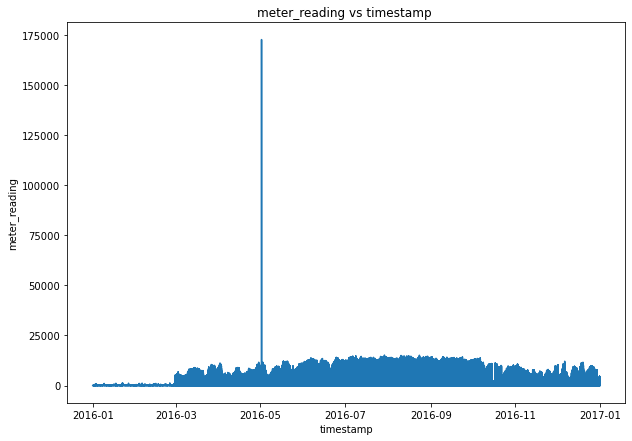

In [11]:
train_0=train[train["site_id"]==0]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(train_0['timestamp'],train_0['meter_reading'])
plt.xlabel("timestamp")
plt.ylabel('meter_reading')
ax.set_title('meter_reading vs timestamp ')
plt.show()

In [12]:
# Compute the sum of meter readings
tot_meter_per_bldg = train[['building_id', 'meter_reading']].groupby('building_id').sum()
# Join with bldg_meta based on building_id
tot_meter_per_bldg = meta.merge(tot_meter_per_bldg, on='building_id')
tot_meter_per_bldg.rename(columns={'meter_reading': 'tot_meter_reading'}, inplace=True)

### la somme de la consommation dans chaque building

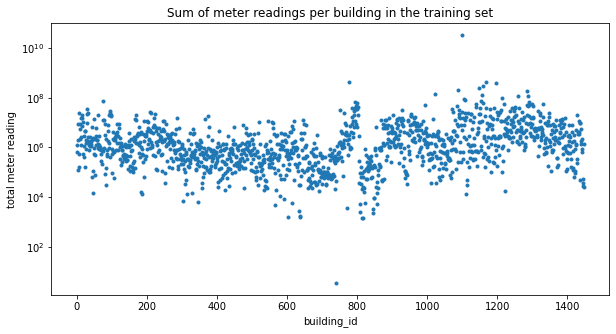

In [14]:
# Make the plot
tot_meter_per_bldg.tot_meter_reading.plot(logy=True, style='.', 
                                          title='Sum of meter readings per building in the training set', 
                                          xlabel='building_id', ylabel='total meter reading',
                                          figsize=(10, 5));